In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate


In [2]:
num_cpns = 3
rv_idx = np.arange(num_cpns).reshape((1,-1))
rv_dt_cpn_ends = rv_idx + 1
rv_cpns = 0.05 + 0.03 * rv_idx


In [3]:
def fn_callable_bond_ytw(cv_y, rv_dt_cpn_ends, rv_cpns):
    """
    return:
    cv_pv_c: pv of the callable bond across cv_y
    mtx_pv_nc: the i-th column is the pv vector across cv_y of the i-th non-callable bond 
    """
    num_cpns = rv_dt_cpn_ends.shape[1]
    mtx_dfs = np.exp(-cv_y * rv_dt_cpn_ends)
    mtx_pv_cpns = np.cumsum(rv_cpns * mtx_dfs, axis = 1)
    mtx_pv_nc = mtx_pv_cpns + mtx_dfs
    cv_pv_c = np.min(mtx_pv_nc, axis=1, keepdims=True)
    
    return cv_pv_c, mtx_pv_nc

def fn_pv_sy_proxy(cv_pv, cv_y, l_xlim, smooth_width = 0.02):
    rv_y = cv_y.T
    mtx_d = rv_y - cv_y
    mtx_w = np.exp(-(mtx_d/smooth_width)**2)
    cv_pv_proxy = np.sum(mtx_w * cv_pv.T, axis = 1, keepdims=True) / np.sum(mtx_w, axis=1, keepdims=True)

    l_ylim = np.interp(l_xlim, cv_y.reshape(-1), (cv_pv_proxy - cv_pv).reshape(-1))
    cv_pv_proxy -= np.interp(cv_y, l_xlim, l_ylim)
    return cv_pv_proxy

def fd_1(cv_x, cv_y):
    vdy = np.empty_like(cv_y)
    vdy[1:-1,:] = (cv_y[2:,:] - cv_y[:-2,:])/(cv_x[2:,:] - cv_x[:-2,:])
    vdy[0,:] = vdy[1,:]
    vdy[-2,:] = vdy[-1,:]
    return vdy

In [4]:
cv_y = np.linspace(-0.2, 0.3, 1000).reshape((-1, 1))
cv_pv_c, mtx_pv_nc = fn_callable_bond_ytw(cv_y, rv_dt_cpn_ends, rv_cpns)


In [5]:
# get the proxy pv function look-like sy (stochastic yield)
v_xlim = [0, 0.15]
cv_pv_sy = fn_pv_sy_proxy(cv_pv_c, cv_y, v_xlim, 0.03)

In [6]:
color_white = np.array([1,1,1])
out_folder = os.path.join(r'..', 'pics')
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [7]:
save_fig = True

In [8]:
cv_pv_scens = np.array([1.0, 0.95, 0.90]).reshape((-1,1))
mtx_ym = np.stack([np.interp(cv_pv_scens[:,0], mtx_pv_nc[-1::-1,i], cv_y[-1::-1,0]) for i in range(mtx_pv_nc.shape[1])]).T
cv_ytw = np.min(mtx_ym, axis=1)
cv_sy = np.interp(cv_pv_scens, cv_pv_sy[-1::-1,0], cv_y[-1::-1,0])

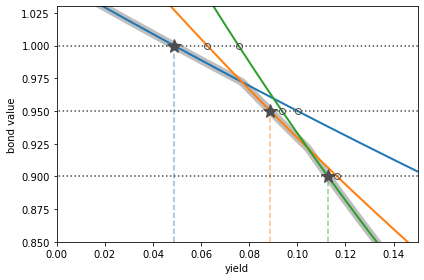

In [9]:
v_ylim = [0.85, 1.03]
plt.figure()
plt.plot(cv_y, mtx_pv_nc, lw= 2)
plt.plot(cv_y, cv_pv_c, c=0.5 * color_white, alpha = 0.5, lw = 8, zorder=-1)
plt.plot(mtx_ym, cv_pv_scens, 'o', fillstyle = 'none', c = 0.3 * color_white)
plt.plot(cv_ytw, cv_pv_scens, '*', ms = 15, c = 0.3 * color_white)

for idx in range(cv_pv_scens.shape[0]):
    p_s = cv_pv_scens[idx]
    plt.plot(cv_y, p_s * np.ones_like(cv_y), ':', c = 0.3 * color_white)
    plt.plot([cv_ytw[idx], cv_ytw[idx]], [v_ylim[0], p_s], '--', alpha = 0.5, c = line_colors[idx], zorder = -1)
plt.xlim(v_xlim)
plt.ylim(v_ylim)
plt.xlabel('yield')
plt.ylabel('bond value')
plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_folder, 'pv-ytw.png'))
plt.show()

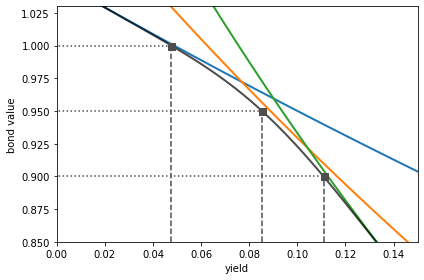

In [10]:
plt.figure()
plt.plot(cv_y, mtx_pv_nc, lw= 2)
plt.plot(cv_y, cv_pv_sy, 'k', alpha = 0.7, lw = 2)
plt.plot(cv_sy, cv_pv_scens, 's', ms = 7, c = 0.3 * color_white)
for idx in range(cv_pv_scens.shape[0]):
    p_s = cv_pv_scens[idx]
    plt.plot([cv_y[0], cv_sy[idx]], [p_s, p_s], ':', c = 0.3 * color_white)
    plt.plot([cv_sy[idx], cv_sy[idx]], [v_ylim[0], p_s], '--', c = 0.3 * color_white)
plt.xlim(v_xlim)
plt.ylim(v_ylim)
plt.xlabel('yield')
plt.ylabel('bond value')
plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_folder, 'pv-sy.png'))
plt.show()

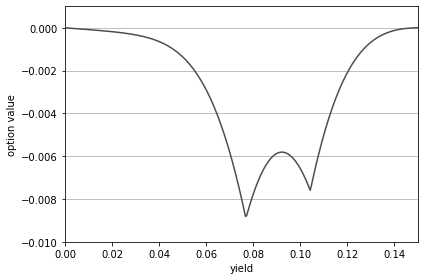

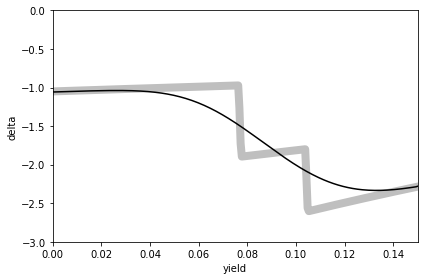

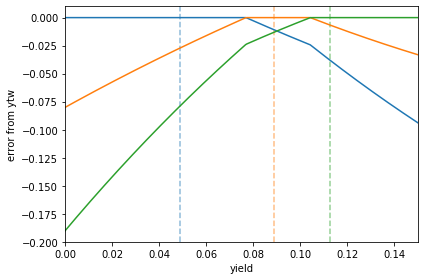

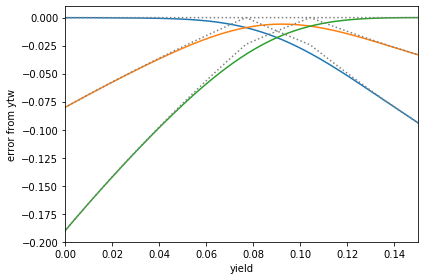

In [11]:
plt.figure()
plt.plot(cv_y, cv_pv_sy - cv_pv_c, c=0.3 * color_white)
plt.xlim(v_xlim)
plt.grid(axis='y')
plt.ylim([-0.01, 0.001])
plt.xlabel('yield')
plt.ylabel('option value')
plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_folder, 'option-value.png'))
plt.show()

plt.figure()
plt.plot(cv_y, fd_1(cv_y, cv_pv_sy), 'k')
plt.plot(cv_y, fd_1(cv_y, cv_pv_c), c=0.5 * color_white, alpha = 0.5, lw = 8, zorder=-1)
plt.xlim(v_xlim)
plt.ylim([-3,0])
plt.xlabel('yield')
plt.ylabel('delta')
plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_folder, 'delta.png'))
plt.show()

v_ylim_err = [-0.2, 0.01]
plt.figure()
plt.plot(cv_y, cv_pv_c - mtx_pv_nc)
for idx in range(cv_pv_scens.shape[0]):
    p_s = cv_pv_scens[idx]
    plt.plot([cv_ytw[idx], cv_ytw[idx]], v_ylim_err, '--', alpha = 0.5, c = line_colors[idx], zorder = -1)

plt.xlim(v_xlim)
plt.ylim(v_ylim_err)
plt.xlabel('yield')
plt.ylabel('error from ytw')
plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_folder, 'error-profile-ytw.png'))
plt.show()

plt.figure()
plt.plot(cv_y, cv_pv_sy - mtx_pv_nc)
plt.plot(cv_y, cv_pv_c - mtx_pv_nc, ':', c = 0.5 * color_white)
plt.xlim(v_xlim)
plt.ylim([-0.2, 0.01])
plt.xlabel('yield')
plt.ylabel('error from ytw')
plt.tight_layout()
if save_fig:
    plt.savefig(os.path.join(out_folder, 'error-profile-sy.png'))
plt.show()


In [12]:

out_folder

'../pics'